# Modelos

En este notebook se probarán distintos modelos para predecir las propinas. El enfoque que se le va a dar al proyecto va a ser el siguiente:
- Modelo de clasificación. En primer lugar, se diseñará un modelo para clasificar los viajes en viajes de propinas bajas y viajes de propinas altas.
- Modelos de regresión. Tras la clasificación inicial, se diseñarán dos modelos de regresión, uno para cada clase.  

Dado que el objetivo principal es identificar el máximo posible de propinas altas ( >10$, clase 1) la métrica que se va a utilizar para evaluar los modelos es el f2-score, que aplica un coeficiente beta al f-score para asignar mas peso al recall en comparación con la precisión



In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Machine learning supervisado
# ==============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn import svm
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, make_scorer, recall_score, precision_score
import xgboost

# Guardar modelos
# ==============================================================================
import pickle


### Carga de datos

In [17]:
df = pd.read_csv('../data/df_yellowtaxi_cleaned.csv', index_col='Unnamed: 0')
df_zones = pd.read_csv('../data/taxi_zone_geo.csv')

In [18]:
df.head()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,congestion_surcharge,Airport_fee,pickup_DoW,pickup_DoW_name,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h),tolls_percentage,tip_amount
1,2.0,3.76506,1.0,236,233,1,14.2,True,2.5,0.00,4,Friday,00:18:40,0,708.0,11.898305,0.0,2.00
2,1.0,2.60658,1.0,162,236,1,8.6,True,2.5,0.00,4,Friday,00:35:01,0,243.0,24.000000,0.0,2.00
4,1.0,15.84865,1.0,138,230,1,45.0,True,2.5,1.75,4,Friday,00:01:23,0,2202.0,16.103542,0.0,17.02
7,1.0,6.27510,1.0,140,7,1,20.5,True,2.5,0.00,4,Friday,00:01:04,0,1052.0,13.346008,0.0,6.35
8,2.0,4.34430,1.0,45,164,1,16.3,True,2.5,0.00,4,Friday,00:37:44,0,880.0,11.045455,0.0,4.26


Se crea la variable target para el clasificador, que se va a llamar tip_category. Valdrá 0 para propinas menores a 10$, y 1 para propinas superiores a 10$

In [19]:
df['tip_category'] = [0 if x<10 else 1 for x in df['tip_amount']]

In [20]:
df['tip_category'].value_counts()

tip_category
0    1760107
1     199172
Name: count, dtype: int64

Para tener como base, se va a probar un primer modelo sencillo, sin realizar transformaciones logarítmicas ni de ningun tipo a ninguna variable.  
Como el dataset tiene una gran cantidad de datos, se va a realizar un muestreo para reducir el tiempo de entrenamiento de los modelos y agilizar el trabajo. El target está muy desbalanceado (aprox 90% clase 0 vs 10% clase 1), por lo tanto se va a realizar un submuestreo únicamente a la clase 0, para tener una representación más parecida de las dos clases

In [21]:
# Separar las clases
class_0 = df[df['tip_category'] == 0]
class_1 = df[df['tip_category'] == 1]

# Submuestreo de la clase mayoritaria
class_0_sampled = class_0.sample(n=int(0.2*len(class_0)), random_state=42)

# Combinar las clases y mezclar
balanced_df = pd.concat([class_0_sampled, class_1]).sample(frac=1, random_state=42)     # con el .sample se mezclan las filas para que no queden ordenadas, ya que al hacer merge quedaron primero todas las de una categoría y luego las de la otra

# Redefinir X e y
X = balanced_df.drop(columns=['tip_amount', 'tip_category', 'RatecodeID', 'payment_type', 'mta_tax', 'pickup_Timestamp', 'pickup_DoW_name'])
y = balanced_df['tip_category']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
pipe = Pipeline(steps=[("scaler", StandardScaler()),
    ('classifier', RandomForestClassifier())
])

random_forest_params = {
    'classifier': [RandomForestClassifier()],
    "classifier__n_estimators": [50, 100],  # Número de árboles
    'classifier__max_depth': [3,4]
}

xgboost_param = {
    'classifier': [xgboost.XGBClassifier()], 
    "classifier__n_estimators": [100, 200],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__max_depth": [3,4]
    
}

search_space = [
    random_forest_params,
    xgboost_param,
]

clf = RandomizedSearchCV(estimator=pipe,                                        # Utilizo RandomizedSearch en lugar de GridSearch porque es más eficiente computacionalmente, aunque no garantice encontrar la solución óptima
                         param_distributions=search_space,
                         n_iter=10,  # Número de combinaciones a probar
                         #cv=5,
                         scoring=make_scorer(fbeta_score, beta=2),  # Evaluar Recall
                         n_jobs=-1)

clf.fit(X_train, y_train)

# Mostrar los resultados
print("Best Parameters:", clf.best_params_)  # Mejores parámetros
print("Best Model:", clf.best_estimator_)   # Mejor modelo

# Evaluar el mejor modelo en el conjunto de prueba
y_pred_train = clf.best_estimator_.predict(X_train)
f2_train = round(fbeta_score(y_train, y_pred_train, beta=2), 3)
print("F2 Score (Train):", f2_train)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = clf.best_estimator_.predict(X_test)
f2_test = round(fbeta_score(y_test, y_pred, beta=2), 3)
print("F2 Score (Test):", f2_test)

Best Parameters: {'classifier__n_estimators': 50, 'classifier__max_depth': 3, 'classifier': RandomForestClassifier()}
Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=3, n_estimators=50))])
F2 Score (Train): 0.938
F2 Score (Test): 0.937


In [23]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     87829
           1       0.92      0.94      0.93     49970

    accuracy                           0.95    137799
   macro avg       0.94      0.95      0.94    137799
weighted avg       0.95      0.95      0.95    137799



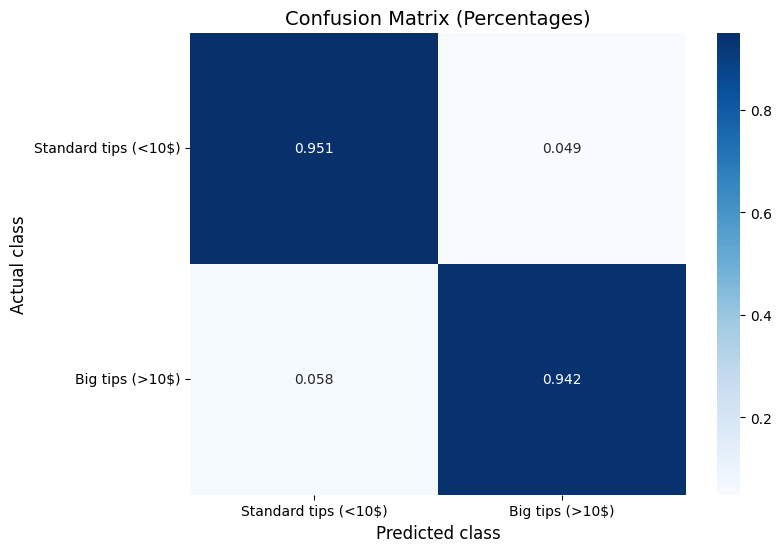

In [24]:
# Generar la matriz de confusión
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Convertir la matriz de confusión a porcentaje
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# Crear el heatmap con porcentajes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".3f", cmap="Blues", cbar=True)

# Cambiar las etiquetas
plt.xlabel('Predicted class', fontsize=12)
plt.ylabel('Actual class', fontsize=12)
plt.xticks([0.5, 1.5], ['Standard tips (<10$)', 'Big tips (>10$)'], fontsize=10)
plt.yticks([0.5, 1.5], ['Standard tips (<10$)', 'Big tips (>10$)'], fontsize=10, rotation=0)

# Título opcional
plt.title('Confusion Matrix (Percentages)', fontsize=14)
plt.show()

                 Feature  Importance
4            fare_amount    0.323177
1          trip_distance    0.282229
11      tolls_percentage    0.170288
6            Airport_fee    0.077369
9          trip_duration    0.076221
10       avg_speed(km/h)    0.043099
2           PULocationID    0.018249
5   congestion_surcharge    0.005962
3           DOLocationID    0.003379
8            pickup_Time    0.000023
7             pickup_DoW    0.000002
0        passenger_count    0.000002


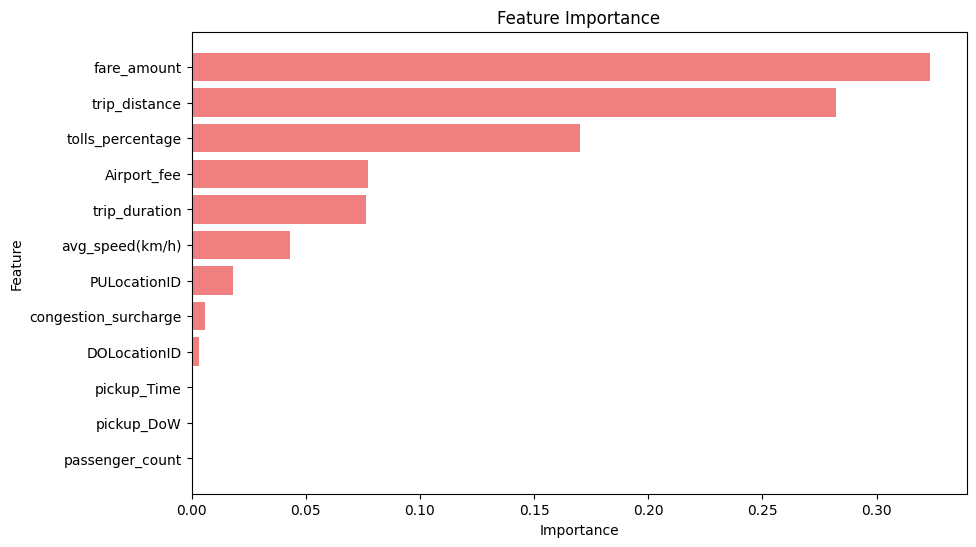

In [27]:
# Vamos a sacar las feature importances de este modelo
# Extraer el modelo del pipeline
final_model = clf.best_estimator_.named_steps['classifier']  

# Obtener las importancias (ejemplo para Random Forest o XGBoost)
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(importance_df)

    # Visualizar
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightcoral')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

Este primer modelo a pesar de su sencillez obtiene un resultado bastante bueno, un 94% de recall.

In [26]:
# Guardamos el modelo en un archivo con pickle
with open('classifier_1.pkl', 'wb') as file:
    pickle.dump(clf.best_estimator_, file)

print("Modelo guardado como 'classifier_1.pkl'")

Modelo guardado como 'classifier_1.pkl'
